# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
import torchvision
import tests

In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [ToTensor()]
    # resize/crop image to size
    transforms.append(torchvision.transforms.Resize(size))
    # output have values [-1, 1]
    transforms.append(torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)))
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        super().__init__()
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.image_paths = glob(directory + f'*{extension}')
        
    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        
        return len(self.image_paths)
    

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        image = self.transforms(image)
        
        return image 

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

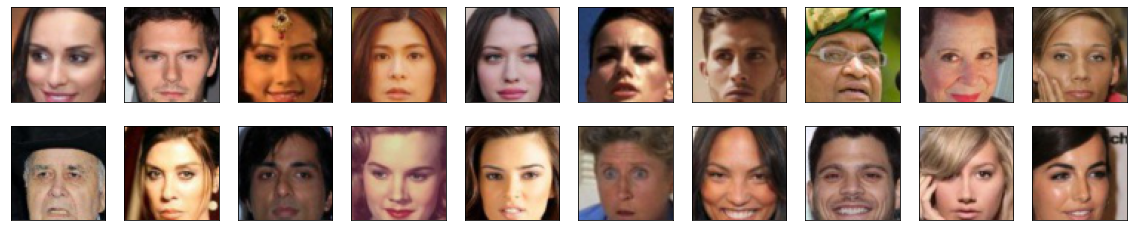

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
from torch.nn import Module
from torch import nn


In [9]:
"""
The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)
"""
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # DCGAN discriminator
        # input 64x64x3
        # output single value (score)

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.leaky_relu3 = nn.LeakyReLU(0.2, inplace=True)

        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(512)
        self.leaky_relu4 = nn.LeakyReLU(0.2, inplace=True)

        # Final convolutional layer to get to a single value
        self.conv5 = nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pass through the layers
        x = self.leaky_relu1(self.conv1(x))
        x = self.leaky_relu2(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu3(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu4(self.batch_norm4(self.conv4(x)))
        x = self.conv5(x)  # This layer outputs the final score

        return x

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()

        # Initial layer - takes latent vector as input
        self.deconv1 = nn.ConvTranspose2d(latent_dim, 512, 4, stride=1, padding=0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU(True)

        # Upscaling layers
        self.deconv2 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ReLU(True)

        self.deconv3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(True)

        self.deconv4 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU(True)

        # Final layer to output 64x64x3 image
        self.deconv5 = nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()  # Tanh activation to get outputs in the range [-1, 1]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu1(self.batch_norm1(self.deconv1(x)))
        x = self.relu2(self.batch_norm2(self.deconv2(x)))
        x = self.relu3(self.batch_norm3(self.deconv3(x)))
        x = self.relu4(self.batch_norm4(self.deconv4(x)))
        x = self.tanh(self.deconv5(x))
        return x

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [13]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [14]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    
        # Create target labels which are all ones (real)
    target_labels = torch.ones_like(fake_logits)

    # Use binary cross-entropy loss
    criterion = nn.BCEWithLogitsLoss()

    # Calculate the loss
    loss = criterion(fake_logits, target_labels)
    
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [15]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    
    # Create target labels for the discriminator
    real_target_labels = torch.ones_like(real_logits)
    fake_target_labels = torch.zeros_like(fake_logits)
    
    # Use binary cross-entropy loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate the loss for real and fake data
    real_loss = criterion(real_logits, real_target_labels)
    fake_loss = criterion(fake_logits, fake_target_labels)
    
    # Calculate total discriminator loss
    loss = real_loss + fake_loss
    
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [16]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # Calculate interpolation
    alpha = torch.rand(real_samples.shape[0], 1, 1, 1)
    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates.requires_grad_(True)
    
    # Calculate probabilities of interpolated examples
    probabilities = discriminator(interpolates)
    
    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=probabilities, inputs=interpolates,
                              grad_outputs=torch.ones_like(probabilities),
                              create_graph=True, retain_graph=True)[0]
    
    # Calculate the penalty using these gradients
    gradients = gradients.view(gradients.shape[0], -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [17]:
from torch.autograd import Variable

def generator_step(generator: nn.Module, discriminator: nn.Module, 
                   batch_size: int, latent_dim: int, 
                   optimizer) -> Dict:
    # Generate noise
    noise = Variable(torch.randn(batch_size, latent_dim, 1, 1)).to("cuda")

    # Generate fake images
    fake_images = generator(noise)

    # Get discriminator's predictions on fake images
    fake_logits = discriminator(fake_images)

    # Calculate generator's loss
    g_loss = generator_loss(fake_logits)

    # Perform backpropagation
    optimizer.zero_grad()  # Clear existing gradients
    g_loss.backward()      # Calculate new gradients
    optimizer.step()       # Update generator's weights

    return {'loss': g_loss.item()}


def discriminator_step(generator: nn.Module, discriminator: nn.Module, 
                       batch_size: int, latent_dim: int, real_images: torch.Tensor, 
                       optimizer, calculate_gp: bool = False) -> Dict:
    # Generate noise
    noise = Variable(torch.randn(batch_size, latent_dim, 1, 1)).to("cuda")

    # Generate fake images
    fake_images = generator(noise).detach()  # Detach to avoid training generator

    # Get discriminator's predictions on real and fake images
    real_logits = discriminator(real_images)
    fake_logits = discriminator(fake_images)

    # Calculate discriminator's loss
    d_loss = discriminator_loss(real_logits, fake_logits)

    # Optionally calculate gradient penalty (for WGAN-GP, for example)
    gp = 0
    if calculate_gp:
        gp = gradient_penalty(discriminator, real_images, fake_images)
        d_loss += gp

    # Perform backpropagation
    optimizer.zero_grad()  # Clear existing gradients
    d_loss.backward()      # Calculate new gradients
    optimizer.step()       # Update discriminator's weights

    return {'loss': d_loss.item(), 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [18]:
from datetime import datetime

In [19]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 3

# number of images in each batch
batch_size = 64

In [20]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

torch.Size([16, 128, 1, 1])
Epoch 1/3
batch_i 0
torch.Size([64, 3, 64, 64])
{'loss': 1.4359347820281982, 'gp': 0}
<class 'dict'>
{'loss': 2.021127223968506}
2024-01-02 12:52:29 | Epoch [1/3] | Batch 0/509 | d_loss: 1.4359 | g_loss: 2.0211
batch_i 1
torch.Size([64, 3, 64, 64])
{'loss': 1.1194976568222046, 'gp': 0}
<class 'dict'>
{'loss': 3.0598599910736084}
batch_i 2
torch.Size([64, 3, 64, 64])
{'loss': 0.5765524506568909, 'gp': 0}
<class 'dict'>
{'loss': 4.120253086090088}
batch_i 3
torch.Size([64, 3, 64, 64])
{'loss': 0.3131982982158661, 'gp': 0}
<class 'dict'>
{'loss': 4.324916362762451}
batch_i 4
torch.Size([64, 3, 64, 64])
{'loss': 0.4311719536781311, 'gp': 0}
<class 'dict'>
{'loss': 4.366983413696289}
batch_i 5
torch.Size([64, 3, 64, 64])
{'loss': 0.3458521366119385, 'gp': 0}
<class 'dict'>
{'loss': 5.334212303161621}
batch_i 6
torch.Size([64, 3, 64, 64])
{'loss': 0.26551079750061035, 'gp': 0}
<class 'dict'>
{'loss': 5.463658332824707}
batch_i 7
torch.Size([64, 3, 64, 64])
{'loss'

<class 'dict'>
{'loss': 11.840009689331055}
batch_i 67
torch.Size([64, 3, 64, 64])
{'loss': 0.21919770538806915, 'gp': 0}
<class 'dict'>
{'loss': 8.409673690795898}
batch_i 68
torch.Size([64, 3, 64, 64])
{'loss': 0.1464194655418396, 'gp': 0}
<class 'dict'>
{'loss': 3.4666333198547363}
batch_i 69
torch.Size([64, 3, 64, 64])
{'loss': 2.622300624847412, 'gp': 0}
<class 'dict'>
{'loss': 10.245174407958984}
batch_i 70
torch.Size([64, 3, 64, 64])
{'loss': 0.6070085167884827, 'gp': 0}
<class 'dict'>
{'loss': 9.96430778503418}
batch_i 71
torch.Size([64, 3, 64, 64])
{'loss': 0.5602442622184753, 'gp': 0}
<class 'dict'>
{'loss': 6.425739765167236}
batch_i 72
torch.Size([64, 3, 64, 64])
{'loss': 0.3280743360519409, 'gp': 0}
<class 'dict'>
{'loss': 3.9832794666290283}
batch_i 73
torch.Size([64, 3, 64, 64])
{'loss': 1.1539522409439087, 'gp': 0}
<class 'dict'>
{'loss': 9.16802978515625}
batch_i 74
torch.Size([64, 3, 64, 64])
{'loss': 0.6552951335906982, 'gp': 0}
<class 'dict'>
{'loss': 8.596797943115

{'loss': 0.39783358573913574, 'gp': 0}
<class 'dict'>
{'loss': 2.638248920440674}
batch_i 136
torch.Size([64, 3, 64, 64])
{'loss': 0.4560755789279938, 'gp': 0}
<class 'dict'>
{'loss': 2.855748176574707}
batch_i 137
torch.Size([64, 3, 64, 64])
{'loss': 0.40884366631507874, 'gp': 0}
<class 'dict'>
{'loss': 3.2698187828063965}
batch_i 138
torch.Size([64, 3, 64, 64])
{'loss': 0.7067615985870361, 'gp': 0}
<class 'dict'>
{'loss': 3.2591724395751953}
batch_i 139
torch.Size([64, 3, 64, 64])
{'loss': 0.7394134402275085, 'gp': 0}
<class 'dict'>
{'loss': 4.28255558013916}
batch_i 140
torch.Size([64, 3, 64, 64])
{'loss': 0.6604936122894287, 'gp': 0}
<class 'dict'>
{'loss': 3.959165096282959}
batch_i 141
torch.Size([64, 3, 64, 64])
{'loss': 0.5888559818267822, 'gp': 0}
<class 'dict'>
{'loss': 5.641934394836426}
batch_i 142
torch.Size([64, 3, 64, 64])
{'loss': 0.33770424127578735, 'gp': 0}
<class 'dict'>
{'loss': 4.3522233963012695}
batch_i 143
torch.Size([64, 3, 64, 64])
{'loss': 0.3947426080703735

{'loss': 0.5493981242179871, 'gp': 0}
<class 'dict'>
{'loss': 3.923250436782837}
batch_i 203
torch.Size([64, 3, 64, 64])
{'loss': 0.7598435878753662, 'gp': 0}
<class 'dict'>
{'loss': 2.138749122619629}
batch_i 204
torch.Size([64, 3, 64, 64])
{'loss': 0.8162699341773987, 'gp': 0}
<class 'dict'>
{'loss': 3.8735547065734863}
batch_i 205
torch.Size([64, 3, 64, 64])
{'loss': 0.44399863481521606, 'gp': 0}
<class 'dict'>
{'loss': 3.2972450256347656}
batch_i 206
torch.Size([64, 3, 64, 64])
{'loss': 0.41152942180633545, 'gp': 0}
<class 'dict'>
{'loss': 2.7865946292877197}
batch_i 207
torch.Size([64, 3, 64, 64])
{'loss': 0.6243366003036499, 'gp': 0}
<class 'dict'>
{'loss': 4.311288833618164}
batch_i 208
torch.Size([64, 3, 64, 64])
{'loss': 0.5642666816711426, 'gp': 0}
<class 'dict'>
{'loss': 2.652158498764038}
batch_i 209
torch.Size([64, 3, 64, 64])
{'loss': 0.48306286334991455, 'gp': 0}
<class 'dict'>
{'loss': 3.831912040710449}
batch_i 210
torch.Size([64, 3, 64, 64])
{'loss': 0.222861409187316

{'loss': 0.7851214408874512, 'gp': 0}
<class 'dict'>
{'loss': 0.9567520618438721}
batch_i 270
torch.Size([64, 3, 64, 64])
{'loss': 2.287733793258667, 'gp': 0}
<class 'dict'>
{'loss': 8.785100936889648}
batch_i 271
torch.Size([64, 3, 64, 64])
{'loss': 3.3826119899749756, 'gp': 0}
<class 'dict'>
{'loss': 6.25891637802124}
batch_i 272
torch.Size([64, 3, 64, 64])
{'loss': 2.06020450592041, 'gp': 0}
<class 'dict'>
{'loss': 1.7256090641021729}
batch_i 273
torch.Size([64, 3, 64, 64])
{'loss': 0.9782753586769104, 'gp': 0}
<class 'dict'>
{'loss': 1.598926067352295}
batch_i 274
torch.Size([64, 3, 64, 64])
{'loss': 0.9158433079719543, 'gp': 0}
<class 'dict'>
{'loss': 3.4195809364318848}
batch_i 275
torch.Size([64, 3, 64, 64])
{'loss': 0.4217211604118347, 'gp': 0}
<class 'dict'>
{'loss': 3.5520052909851074}
batch_i 276
torch.Size([64, 3, 64, 64])
{'loss': 0.537638247013092, 'gp': 0}
<class 'dict'>
{'loss': 2.6533288955688477}
batch_i 277
torch.Size([64, 3, 64, 64])
{'loss': 0.8034341335296631, 'gp

<class 'dict'>
{'loss': 3.077604293823242}
batch_i 337
torch.Size([64, 3, 64, 64])
{'loss': 0.42541396617889404, 'gp': 0}
<class 'dict'>
{'loss': 3.503713607788086}
batch_i 338
torch.Size([64, 3, 64, 64])
{'loss': 0.3712140917778015, 'gp': 0}
<class 'dict'>
{'loss': 2.9082648754119873}
batch_i 339
torch.Size([64, 3, 64, 64])
{'loss': 0.33350953459739685, 'gp': 0}
<class 'dict'>
{'loss': 2.7671494483947754}
batch_i 340
torch.Size([64, 3, 64, 64])
{'loss': 0.5007520914077759, 'gp': 0}
<class 'dict'>
{'loss': 3.6767373085021973}
batch_i 341
torch.Size([64, 3, 64, 64])
{'loss': 0.33992907404899597, 'gp': 0}
<class 'dict'>
{'loss': 3.9800865650177}
batch_i 342
torch.Size([64, 3, 64, 64])
{'loss': 0.6369461417198181, 'gp': 0}
<class 'dict'>
{'loss': 1.1383204460144043}
batch_i 343
torch.Size([64, 3, 64, 64])
{'loss': 1.6850428581237793, 'gp': 0}
<class 'dict'>
{'loss': 8.324493408203125}
batch_i 344
torch.Size([64, 3, 64, 64])
{'loss': 3.3483927249908447, 'gp': 0}
<class 'dict'>
{'loss': 4.3

{'loss': 0.5978797674179077, 'gp': 0}
<class 'dict'>
{'loss': 2.0323967933654785}
batch_i 405
torch.Size([64, 3, 64, 64])
{'loss': 0.6606045961380005, 'gp': 0}
<class 'dict'>
{'loss': 4.971325874328613}
batch_i 406
torch.Size([64, 3, 64, 64])
{'loss': 0.4471549689769745, 'gp': 0}
<class 'dict'>
{'loss': 3.2335386276245117}
batch_i 407
torch.Size([64, 3, 64, 64])
{'loss': 0.2829071879386902, 'gp': 0}
<class 'dict'>
{'loss': 2.2665514945983887}
batch_i 408
torch.Size([64, 3, 64, 64])
{'loss': 0.21302887797355652, 'gp': 0}
<class 'dict'>
{'loss': 3.3342485427856445}
batch_i 409
torch.Size([64, 3, 64, 64])
{'loss': 0.38753411173820496, 'gp': 0}
<class 'dict'>
{'loss': 5.028233528137207}
batch_i 410
torch.Size([64, 3, 64, 64])
{'loss': 0.7948262691497803, 'gp': 0}
<class 'dict'>
{'loss': 1.5466614961624146}
batch_i 411
torch.Size([64, 3, 64, 64])
{'loss': 0.7429636716842651, 'gp': 0}
<class 'dict'>
{'loss': 4.981358051300049}
batch_i 412
torch.Size([64, 3, 64, 64])
{'loss': 0.46534341573715

<class 'dict'>
{'loss': 4.172887325286865}
batch_i 473
torch.Size([64, 3, 64, 64])
{'loss': 0.35430049896240234, 'gp': 0}
<class 'dict'>
{'loss': 4.907045364379883}
batch_i 474
torch.Size([64, 3, 64, 64])
{'loss': 0.7021774053573608, 'gp': 0}
<class 'dict'>
{'loss': 2.0435309410095215}
batch_i 475
torch.Size([64, 3, 64, 64])
{'loss': 0.5871362686157227, 'gp': 0}
<class 'dict'>
{'loss': 6.201117992401123}
batch_i 476
torch.Size([64, 3, 64, 64])
{'loss': 0.49289971590042114, 'gp': 0}
<class 'dict'>
{'loss': 3.6777241230010986}
batch_i 477
torch.Size([64, 3, 64, 64])
{'loss': 0.21064943075180054, 'gp': 0}
<class 'dict'>
{'loss': 3.6015594005584717}
batch_i 478
torch.Size([64, 3, 64, 64])
{'loss': 0.11066457629203796, 'gp': 0}
<class 'dict'>
{'loss': 4.381819725036621}
batch_i 479
torch.Size([64, 3, 64, 64])
{'loss': 0.6362831592559814, 'gp': 0}
<class 'dict'>
{'loss': 7.609259128570557}
batch_i 480
torch.Size([64, 3, 64, 64])
{'loss': 2.0238096714019775, 'gp': 0}
<class 'dict'>
{'loss': 0

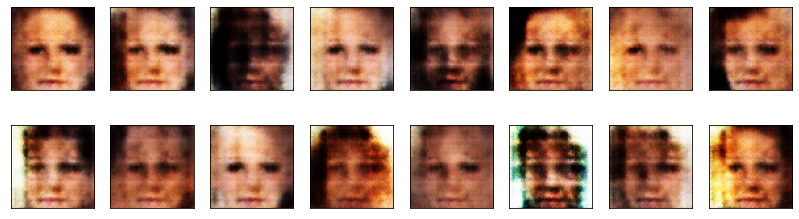

Epoch 2/3
batch_i 0
torch.Size([64, 3, 64, 64])
{'loss': 0.6334398984909058, 'gp': 0}
<class 'dict'>
{'loss': 2.621232748031616}
2024-01-02 12:53:36 | Epoch [2/3] | Batch 0/509 | d_loss: 0.6334 | g_loss: 2.6212
batch_i 1
torch.Size([64, 3, 64, 64])
{'loss': 0.666151225566864, 'gp': 0}
<class 'dict'>
{'loss': 2.842186689376831}
batch_i 2
torch.Size([64, 3, 64, 64])
{'loss': 0.6025511026382446, 'gp': 0}
<class 'dict'>
{'loss': 4.577934741973877}
batch_i 3
torch.Size([64, 3, 64, 64])
{'loss': 0.7660130858421326, 'gp': 0}
<class 'dict'>
{'loss': 1.897496223449707}
batch_i 4
torch.Size([64, 3, 64, 64])
{'loss': 0.9936926960945129, 'gp': 0}
<class 'dict'>
{'loss': 6.7489190101623535}
batch_i 5
torch.Size([64, 3, 64, 64])
{'loss': 0.8732571601867676, 'gp': 0}
<class 'dict'>
{'loss': 4.299402236938477}
batch_i 6
torch.Size([64, 3, 64, 64])
{'loss': 0.344669908285141, 'gp': 0}
<class 'dict'>
{'loss': 2.727334976196289}
batch_i 7
torch.Size([64, 3, 64, 64])
{'loss': 0.722943902015686, 'gp': 0}
<

<class 'dict'>
{'loss': 4.452531337738037}
batch_i 69
torch.Size([64, 3, 64, 64])
{'loss': 0.677864670753479, 'gp': 0}
<class 'dict'>
{'loss': 7.556722164154053}
batch_i 70
torch.Size([64, 3, 64, 64])
{'loss': 1.18669593334198, 'gp': 0}
<class 'dict'>
{'loss': 2.987639904022217}
batch_i 71
torch.Size([64, 3, 64, 64])
{'loss': 0.25740137696266174, 'gp': 0}
<class 'dict'>
{'loss': 4.443477630615234}
batch_i 72
torch.Size([64, 3, 64, 64])
{'loss': 0.1877162605524063, 'gp': 0}
<class 'dict'>
{'loss': 5.5709919929504395}
batch_i 73
torch.Size([64, 3, 64, 64])
{'loss': 0.2047082483768463, 'gp': 0}
<class 'dict'>
{'loss': 4.673619270324707}
batch_i 74
torch.Size([64, 3, 64, 64])
{'loss': 0.25111645460128784, 'gp': 0}
<class 'dict'>
{'loss': 4.394069671630859}
batch_i 75
torch.Size([64, 3, 64, 64])
{'loss': 0.3292080760002136, 'gp': 0}
<class 'dict'>
{'loss': 4.653086185455322}
batch_i 76
torch.Size([64, 3, 64, 64])
{'loss': 0.3208613395690918, 'gp': 0}
<class 'dict'>
{'loss': 3.24054455757141

<class 'dict'>
{'loss': 7.081463813781738}
batch_i 137
torch.Size([64, 3, 64, 64])
{'loss': 0.3697999119758606, 'gp': 0}
<class 'dict'>
{'loss': 3.339366912841797}
batch_i 138
torch.Size([64, 3, 64, 64])
{'loss': 0.906980037689209, 'gp': 0}
<class 'dict'>
{'loss': 5.276983737945557}
batch_i 139
torch.Size([64, 3, 64, 64])
{'loss': 0.4027648866176605, 'gp': 0}
<class 'dict'>
{'loss': 6.098423957824707}
batch_i 140
torch.Size([64, 3, 64, 64])
{'loss': 0.5410151481628418, 'gp': 0}
<class 'dict'>
{'loss': 3.8903117179870605}
batch_i 141
torch.Size([64, 3, 64, 64])
{'loss': 0.6646537780761719, 'gp': 0}
<class 'dict'>
{'loss': 4.923315048217773}
batch_i 142
torch.Size([64, 3, 64, 64])
{'loss': 0.43870097398757935, 'gp': 0}
<class 'dict'>
{'loss': 4.702938079833984}
batch_i 143
torch.Size([64, 3, 64, 64])
{'loss': 0.5125271677970886, 'gp': 0}
<class 'dict'>
{'loss': 3.865436553955078}
batch_i 144
torch.Size([64, 3, 64, 64])
{'loss': 0.663604199886322, 'gp': 0}
<class 'dict'>
{'loss': 5.961399

<class 'dict'>
{'loss': 4.156883239746094}
batch_i 204
torch.Size([64, 3, 64, 64])
{'loss': 0.3244859576225281, 'gp': 0}
<class 'dict'>
{'loss': 3.836301326751709}
batch_i 205
torch.Size([64, 3, 64, 64])
{'loss': 0.3760572075843811, 'gp': 0}
<class 'dict'>
{'loss': 3.424441337585449}
batch_i 206
torch.Size([64, 3, 64, 64])
{'loss': 0.6419656872749329, 'gp': 0}
<class 'dict'>
{'loss': 5.7802886962890625}
batch_i 207
torch.Size([64, 3, 64, 64])
{'loss': 0.658190906047821, 'gp': 0}
<class 'dict'>
{'loss': 3.1853854656219482}
batch_i 208
torch.Size([64, 3, 64, 64])
{'loss': 0.570438027381897, 'gp': 0}
<class 'dict'>
{'loss': 4.79861307144165}
batch_i 209
torch.Size([64, 3, 64, 64])
{'loss': 0.31086266040802, 'gp': 0}
<class 'dict'>
{'loss': 4.395514488220215}
batch_i 210
torch.Size([64, 3, 64, 64])
{'loss': 0.2588465213775635, 'gp': 0}
<class 'dict'>
{'loss': 3.314321994781494}
batch_i 211
torch.Size([64, 3, 64, 64])
{'loss': 0.32928818464279175, 'gp': 0}
<class 'dict'>
{'loss': 3.85139465

{'loss': 0.2501872181892395, 'gp': 0}
<class 'dict'>
{'loss': 4.713232040405273}
batch_i 273
torch.Size([64, 3, 64, 64])
{'loss': 0.3319045603275299, 'gp': 0}
<class 'dict'>
{'loss': 4.633491516113281}
batch_i 274
torch.Size([64, 3, 64, 64])
{'loss': 0.32813239097595215, 'gp': 0}
<class 'dict'>
{'loss': 3.83675479888916}
batch_i 275
torch.Size([64, 3, 64, 64])
{'loss': 0.3423015773296356, 'gp': 0}
<class 'dict'>
{'loss': 5.145599365234375}
batch_i 276
torch.Size([64, 3, 64, 64])
{'loss': 0.2717537581920624, 'gp': 0}
<class 'dict'>
{'loss': 4.758078575134277}
batch_i 277
torch.Size([64, 3, 64, 64])
{'loss': 0.2978399991989136, 'gp': 0}
<class 'dict'>
{'loss': 5.344196319580078}
batch_i 278
torch.Size([64, 3, 64, 64])
{'loss': 0.4339563548564911, 'gp': 0}
<class 'dict'>
{'loss': 1.829802393913269}
batch_i 279
torch.Size([64, 3, 64, 64])
{'loss': 0.9688743352890015, 'gp': 0}
<class 'dict'>
{'loss': 10.391486167907715}
batch_i 280
torch.Size([64, 3, 64, 64])
{'loss': 3.12646222114563, 'gp'

{'loss': 0.2774084508419037, 'gp': 0}
<class 'dict'>
{'loss': 4.749502182006836}
batch_i 341
torch.Size([64, 3, 64, 64])
{'loss': 0.2929859757423401, 'gp': 0}
<class 'dict'>
{'loss': 5.209229469299316}
batch_i 342
torch.Size([64, 3, 64, 64])
{'loss': 0.21511226892471313, 'gp': 0}
<class 'dict'>
{'loss': 4.543215751647949}
batch_i 343
torch.Size([64, 3, 64, 64])
{'loss': 0.4489409327507019, 'gp': 0}
<class 'dict'>
{'loss': 6.062856197357178}
batch_i 344
torch.Size([64, 3, 64, 64])
{'loss': 0.40263301134109497, 'gp': 0}
<class 'dict'>
{'loss': 3.764962673187256}
batch_i 345
torch.Size([64, 3, 64, 64])
{'loss': 0.4229041635990143, 'gp': 0}
<class 'dict'>
{'loss': 7.026038646697998}
batch_i 346
torch.Size([64, 3, 64, 64])
{'loss': 0.3322218656539917, 'gp': 0}
<class 'dict'>
{'loss': 5.215816020965576}
batch_i 347
torch.Size([64, 3, 64, 64])
{'loss': 0.22341328859329224, 'gp': 0}
<class 'dict'>
{'loss': 4.5306878089904785}
batch_i 348
torch.Size([64, 3, 64, 64])
{'loss': 0.49843335151672363

<class 'dict'>
{'loss': 6.089572906494141}
batch_i 408
torch.Size([64, 3, 64, 64])
{'loss': 0.40340813994407654, 'gp': 0}
<class 'dict'>
{'loss': 3.972728729248047}
batch_i 409
torch.Size([64, 3, 64, 64])
{'loss': 0.42981648445129395, 'gp': 0}
<class 'dict'>
{'loss': 7.205989837646484}
batch_i 410
torch.Size([64, 3, 64, 64])
{'loss': 0.6106666326522827, 'gp': 0}
<class 'dict'>
{'loss': 3.3238229751586914}
batch_i 411
torch.Size([64, 3, 64, 64])
{'loss': 0.5200294256210327, 'gp': 0}
<class 'dict'>
{'loss': 6.8181633949279785}
batch_i 412
torch.Size([64, 3, 64, 64])
{'loss': 0.2457946240901947, 'gp': 0}
<class 'dict'>
{'loss': 5.9203572273254395}
batch_i 413
torch.Size([64, 3, 64, 64])
{'loss': 0.08261500298976898, 'gp': 0}
<class 'dict'>
{'loss': 4.155840873718262}
batch_i 414
torch.Size([64, 3, 64, 64])
{'loss': 0.19591780006885529, 'gp': 0}
<class 'dict'>
{'loss': 4.586799621582031}
batch_i 415
torch.Size([64, 3, 64, 64])
{'loss': 0.17696678638458252, 'gp': 0}
<class 'dict'>
{'loss': 

<class 'dict'>
{'loss': 4.915269374847412}
batch_i 476
torch.Size([64, 3, 64, 64])
{'loss': 0.4786522388458252, 'gp': 0}
<class 'dict'>
{'loss': 3.6823596954345703}
batch_i 477
torch.Size([64, 3, 64, 64])
{'loss': 0.388543039560318, 'gp': 0}
<class 'dict'>
{'loss': 4.434012413024902}
batch_i 478
torch.Size([64, 3, 64, 64])
{'loss': 0.4300594627857208, 'gp': 0}
<class 'dict'>
{'loss': 3.5435829162597656}
batch_i 479
torch.Size([64, 3, 64, 64])
{'loss': 0.46886807680130005, 'gp': 0}
<class 'dict'>
{'loss': 4.6536784172058105}
batch_i 480
torch.Size([64, 3, 64, 64])
{'loss': 0.6538088321685791, 'gp': 0}
<class 'dict'>
{'loss': 2.417109489440918}
batch_i 481
torch.Size([64, 3, 64, 64])
{'loss': 1.0397988557815552, 'gp': 0}
<class 'dict'>
{'loss': 9.360546112060547}
batch_i 482
torch.Size([64, 3, 64, 64])
{'loss': 1.163498878479004, 'gp': 0}
<class 'dict'>
{'loss': 6.394416809082031}
batch_i 483
torch.Size([64, 3, 64, 64])
{'loss': 0.15050984919071198, 'gp': 0}
<class 'dict'>
{'loss': 3.042

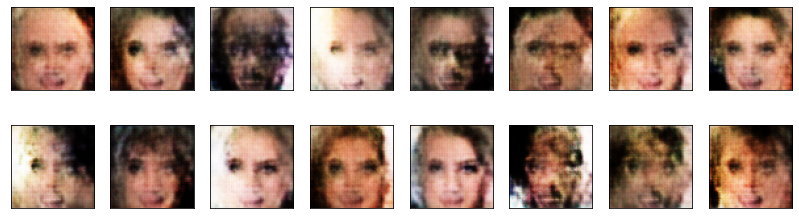

Epoch 3/3
batch_i 0
torch.Size([64, 3, 64, 64])
{'loss': 0.5468902587890625, 'gp': 0}
<class 'dict'>
{'loss': 3.4030447006225586}
2024-01-02 12:54:42 | Epoch [3/3] | Batch 0/509 | d_loss: 0.5469 | g_loss: 3.4030
batch_i 1
torch.Size([64, 3, 64, 64])
{'loss': 0.7138211727142334, 'gp': 0}
<class 'dict'>
{'loss': 5.5666117668151855}
batch_i 2
torch.Size([64, 3, 64, 64])
{'loss': 0.6986573934555054, 'gp': 0}
<class 'dict'>
{'loss': 3.1497724056243896}
batch_i 3
torch.Size([64, 3, 64, 64])
{'loss': 0.8519127368927002, 'gp': 0}
<class 'dict'>
{'loss': 7.153534412384033}
batch_i 4
torch.Size([64, 3, 64, 64])
{'loss': 0.6962410807609558, 'gp': 0}
<class 'dict'>
{'loss': 4.376087188720703}
batch_i 5
torch.Size([64, 3, 64, 64])
{'loss': 0.5225698351860046, 'gp': 0}
<class 'dict'>
{'loss': 4.037465572357178}
batch_i 6
torch.Size([64, 3, 64, 64])
{'loss': 0.5160424113273621, 'gp': 0}
<class 'dict'>
{'loss': 5.97573184967041}
batch_i 7
torch.Size([64, 3, 64, 64])
{'loss': 0.872319221496582, 'gp': 0

{'loss': 0.40713876485824585, 'gp': 0}
<class 'dict'>
{'loss': 3.530029296875}
batch_i 68
torch.Size([64, 3, 64, 64])
{'loss': 0.25524210929870605, 'gp': 0}
<class 'dict'>
{'loss': 4.338658332824707}
batch_i 69
torch.Size([64, 3, 64, 64])
{'loss': 0.38883960247039795, 'gp': 0}
<class 'dict'>
{'loss': 3.4826972484588623}
batch_i 70
torch.Size([64, 3, 64, 64])
{'loss': 0.4364210367202759, 'gp': 0}
<class 'dict'>
{'loss': 5.078121185302734}
batch_i 71
torch.Size([64, 3, 64, 64])
{'loss': 0.2178269624710083, 'gp': 0}
<class 'dict'>
{'loss': 4.403533935546875}
batch_i 72
torch.Size([64, 3, 64, 64])
{'loss': 0.3969501852989197, 'gp': 0}
<class 'dict'>
{'loss': 3.05829119682312}
batch_i 73
torch.Size([64, 3, 64, 64])
{'loss': 0.5440346002578735, 'gp': 0}
<class 'dict'>
{'loss': 2.935245990753174}
batch_i 74
torch.Size([64, 3, 64, 64])
{'loss': 0.6935171484947205, 'gp': 0}
<class 'dict'>
{'loss': 6.189229965209961}
batch_i 75
torch.Size([64, 3, 64, 64])
{'loss': 0.6713595390319824, 'gp': 0}
<c

<class 'dict'>
{'loss': 7.429173469543457}
batch_i 135
torch.Size([64, 3, 64, 64])
{'loss': 1.29232656955719, 'gp': 0}
<class 'dict'>
{'loss': 3.2178282737731934}
batch_i 136
torch.Size([64, 3, 64, 64])
{'loss': 0.6294581890106201, 'gp': 0}
<class 'dict'>
{'loss': 4.517526626586914}
batch_i 137
torch.Size([64, 3, 64, 64])
{'loss': 0.37163734436035156, 'gp': 0}
<class 'dict'>
{'loss': 5.215387344360352}
batch_i 138
torch.Size([64, 3, 64, 64])
{'loss': 0.4436049461364746, 'gp': 0}
<class 'dict'>
{'loss': 3.2711076736450195}
batch_i 139
torch.Size([64, 3, 64, 64])
{'loss': 0.7264441847801208, 'gp': 0}
<class 'dict'>
{'loss': 3.3527212142944336}
batch_i 140
torch.Size([64, 3, 64, 64])
{'loss': 0.5848060846328735, 'gp': 0}
<class 'dict'>
{'loss': 4.314007759094238}
batch_i 141
torch.Size([64, 3, 64, 64])
{'loss': 0.6289176940917969, 'gp': 0}
<class 'dict'>
{'loss': 3.2634341716766357}
batch_i 142
torch.Size([64, 3, 64, 64])
{'loss': 0.7573708295822144, 'gp': 0}
<class 'dict'>
{'loss': 5.948

<class 'dict'>
{'loss': 2.5694570541381836}
batch_i 203
torch.Size([64, 3, 64, 64])
{'loss': 0.6516344547271729, 'gp': 0}
<class 'dict'>
{'loss': 6.2283196449279785}
batch_i 204
torch.Size([64, 3, 64, 64])
{'loss': 0.8817898035049438, 'gp': 0}
<class 'dict'>
{'loss': 2.0433883666992188}
batch_i 205
torch.Size([64, 3, 64, 64])
{'loss': 1.108319878578186, 'gp': 0}
<class 'dict'>
{'loss': 8.482189178466797}
batch_i 206
torch.Size([64, 3, 64, 64])
{'loss': 0.8150554299354553, 'gp': 0}
<class 'dict'>
{'loss': 5.2697529792785645}
batch_i 207
torch.Size([64, 3, 64, 64])
{'loss': 0.20561927556991577, 'gp': 0}
<class 'dict'>
{'loss': 2.8428289890289307}
batch_i 208
torch.Size([64, 3, 64, 64])
{'loss': 1.0323612689971924, 'gp': 0}
<class 'dict'>
{'loss': 7.6324615478515625}
batch_i 209
torch.Size([64, 3, 64, 64])
{'loss': 0.7267013788223267, 'gp': 0}
<class 'dict'>
{'loss': 5.085752010345459}
batch_i 210
torch.Size([64, 3, 64, 64])
{'loss': 0.3265646696090698, 'gp': 0}
<class 'dict'>
{'loss': 2.

<class 'dict'>
{'loss': 1.5377610921859741}
batch_i 271
torch.Size([64, 3, 64, 64])
{'loss': 0.957118034362793, 'gp': 0}
<class 'dict'>
{'loss': 3.1068220138549805}
batch_i 272
torch.Size([64, 3, 64, 64])
{'loss': 0.34381920099258423, 'gp': 0}
<class 'dict'>
{'loss': 4.413472652435303}
batch_i 273
torch.Size([64, 3, 64, 64])
{'loss': 0.6310725212097168, 'gp': 0}
<class 'dict'>
{'loss': 3.515683174133301}
batch_i 274
torch.Size([64, 3, 64, 64])
{'loss': 0.7499330639839172, 'gp': 0}
<class 'dict'>
{'loss': 3.245553970336914}
batch_i 275
torch.Size([64, 3, 64, 64])
{'loss': 1.2141709327697754, 'gp': 0}
<class 'dict'>
{'loss': 3.9258391857147217}
batch_i 276
torch.Size([64, 3, 64, 64])
{'loss': 0.7949941158294678, 'gp': 0}
<class 'dict'>
{'loss': 5.017448425292969}
batch_i 277
torch.Size([64, 3, 64, 64])
{'loss': 0.6279000043869019, 'gp': 0}
<class 'dict'>
{'loss': 3.0476198196411133}
batch_i 278
torch.Size([64, 3, 64, 64])
{'loss': 0.9120986461639404, 'gp': 0}
<class 'dict'>
{'loss': 6.11

<class 'dict'>
{'loss': 3.9831948280334473}
batch_i 339
torch.Size([64, 3, 64, 64])
{'loss': 0.387320339679718, 'gp': 0}
<class 'dict'>
{'loss': 3.785402297973633}
batch_i 340
torch.Size([64, 3, 64, 64])
{'loss': 0.40109485387802124, 'gp': 0}
<class 'dict'>
{'loss': 3.929621696472168}
batch_i 341
torch.Size([64, 3, 64, 64])
{'loss': 0.5436315536499023, 'gp': 0}
<class 'dict'>
{'loss': 2.715672492980957}
batch_i 342
torch.Size([64, 3, 64, 64])
{'loss': 0.7281516790390015, 'gp': 0}
<class 'dict'>
{'loss': 5.874914169311523}
batch_i 343
torch.Size([64, 3, 64, 64])
{'loss': 0.9023841023445129, 'gp': 0}
<class 'dict'>
{'loss': 2.230448007583618}
batch_i 344
torch.Size([64, 3, 64, 64])
{'loss': 0.7480096220970154, 'gp': 0}
<class 'dict'>
{'loss': 5.08302116394043}
batch_i 345
torch.Size([64, 3, 64, 64])
{'loss': 0.30606216192245483, 'gp': 0}
<class 'dict'>
{'loss': 4.454239845275879}
batch_i 346
torch.Size([64, 3, 64, 64])
{'loss': 0.24608071148395538, 'gp': 0}
<class 'dict'>
{'loss': 3.1889

<class 'dict'>
{'loss': 2.936225414276123}
batch_i 406
torch.Size([64, 3, 64, 64])
{'loss': 0.7783576250076294, 'gp': 0}
<class 'dict'>
{'loss': 6.276549816131592}
batch_i 407
torch.Size([64, 3, 64, 64])
{'loss': 1.2266429662704468, 'gp': 0}
<class 'dict'>
{'loss': 1.8399858474731445}
batch_i 408
torch.Size([64, 3, 64, 64])
{'loss': 0.9723352193832397, 'gp': 0}
<class 'dict'>
{'loss': 6.396736145019531}
batch_i 409
torch.Size([64, 3, 64, 64])
{'loss': 0.7368296980857849, 'gp': 0}
<class 'dict'>
{'loss': 4.433845520019531}
batch_i 410
torch.Size([64, 3, 64, 64])
{'loss': 0.2057107388973236, 'gp': 0}
<class 'dict'>
{'loss': 3.4353904724121094}
batch_i 411
torch.Size([64, 3, 64, 64])
{'loss': 0.3902061879634857, 'gp': 0}
<class 'dict'>
{'loss': 5.160795211791992}
batch_i 412
torch.Size([64, 3, 64, 64])
{'loss': 0.19379107654094696, 'gp': 0}
<class 'dict'>
{'loss': 5.345890998840332}
batch_i 413
torch.Size([64, 3, 64, 64])
{'loss': 0.2228875607252121, 'gp': 0}
<class 'dict'>
{'loss': 3.699

{'loss': 0.8104610443115234, 'gp': 0}
<class 'dict'>
{'loss': 4.000761985778809}
batch_i 474
torch.Size([64, 3, 64, 64])
{'loss': 0.41228023171424866, 'gp': 0}
<class 'dict'>
{'loss': 1.8614892959594727}
batch_i 475
torch.Size([64, 3, 64, 64])
{'loss': 0.9786813259124756, 'gp': 0}
<class 'dict'>
{'loss': 7.18493127822876}
batch_i 476
torch.Size([64, 3, 64, 64])
{'loss': 0.4045262634754181, 'gp': 0}
<class 'dict'>
{'loss': 5.922268867492676}
batch_i 477
torch.Size([64, 3, 64, 64])
{'loss': 0.39791005849838257, 'gp': 0}
<class 'dict'>
{'loss': 2.7019808292388916}
batch_i 478
torch.Size([64, 3, 64, 64])
{'loss': 0.7179421186447144, 'gp': 0}
<class 'dict'>
{'loss': 6.021779537200928}
batch_i 479
torch.Size([64, 3, 64, 64])
{'loss': 0.42020413279533386, 'gp': 0}
<class 'dict'>
{'loss': 3.90608549118042}
batch_i 480
torch.Size([64, 3, 64, 64])
{'loss': 0.3322879672050476, 'gp': 0}
<class 'dict'>
{'loss': 3.4292221069335938}
batch_i 481
torch.Size([64, 3, 64, 64])
{'loss': 0.2949574291706085,

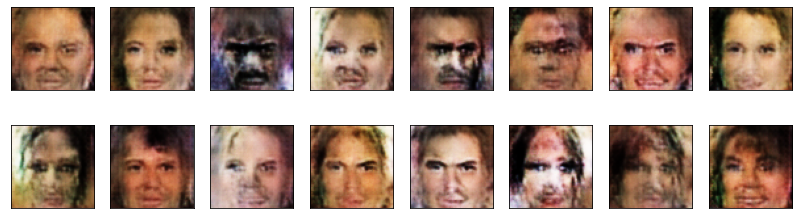

In [22]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()
print(fixed_latent_vector.shape)
losses = []
for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    for batch_i, real_images in enumerate(dataloader):
        print("batch_i", batch_i)
        real_images = real_images.to(device)
        print(real_images.shape)
          
        # Discriminator Training Step
        d_loss = discriminator_step(generator, discriminator, 
                                    real_images.size(0), latent_dim, 
                                    real_images, d_optimizer)
        print(d_loss)
        # Generator Training Step
        g_loss = generator_step(generator, discriminator, 
                                real_images.size(0), latent_dim, 
                                g_optimizer)
        print(type(g_loss))
        print(g_loss)
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss']
            g = g_loss['loss']
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

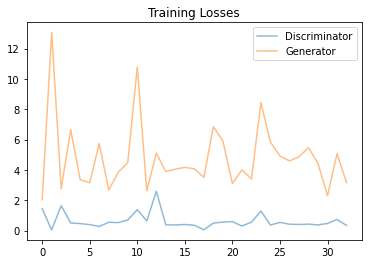

In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)
Dataset Bias:

Observation: The current dataset, predominantly featuring "celebrity" faces that are mostly white, limits the diversity of the generated samples. The model appears to replicate this bias, primarily producing faces with similar features and lacking variety in skin tones and ethnic characteristics.
Improvement: To address this, I need to use a more diverse and representative dataset, encompassing a broader range of ethnicities, skin tones, and facial features. This will enable the model to learn and generate a more inclusive variety of faces, reducing the bias in the output.
Model Size:

Observation: The current model might be too small to capture the full complexity and diversity of human faces. This can lead to oversimplified or less detailed generated images.
Improvement: Scaling up the model by increasing the depth (number of layers) and width (number of units in each layer) could enable it to learn more complex and nuanced features. However, I must balance this with the available computational resources and the risk of overfitting, especially if the dataset size is limited.
Optimization Strategy:

Observation: The choice of optimizer and the number of training epochs significantly influence the model's performance. If not optimized correctly, the model may not converge effectively, leading to subpar image quality.
Improvement: Experimenting with different optimizers, such as Adam or RMSprop, and fine-tuning their parameters (like learning rate) could yield better results. Additionally, increasing the number of training epochs might allow more comprehensive learning, but I should monitor for signs of overfitting.
Loss Functions:

Observation: The effectiveness of the loss function in guiding the learning process is crucial. If the loss function does not adequately penalize poor generation or provide meaningful gradients, the quality of generated images can be affected.
Improvement: Exploring alternative loss functions, such as Wasserstein loss or hinge loss, might improve training dynamics and output quality. These alternatives can offer more stable training and better convergence properties, potentially leading to higher-quality generated images.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.